# Local Interpretability

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [ ]:
#default_exp core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#exporti
from fastai.vision import *
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gif
import math
import numpy as np
import torchvision
import altair as alt
import warnings
warnings.filterwarnings('ignore')

## Evaluation functions

In [ ]:
#exporti
def dice_by_component(predictedMask, trueMask, component = 1):
    dice = Tensor([1])
    pred = predictedMask.data == component
    msk = trueMask.data == component
    intersect = pred&msk
    total = pred.sum() + msk.sum() 
    if total > 0:
        dice = 2 * intersect.sum().float() / total
    return dice.item()

In [ ]:
#exporti
def recall_by_component(predictedMask, trueMask, component = 1):
    recall = Tensor([1])
    pred = predictedMask.data == component
    msk = trueMask.data == component
    intersect = pred&msk
    total = pred.sum() + msk.sum() 
    if total > 0:
        recall = intersect.sum().float() / msk.sum()
    return recall.item()

In [ ]:
#exporti
def precision_by_component(predictedMask, trueMask, component = 1):
    precision = Tensor([1])
    pred = predictedMask.data == component
    msk = trueMask.data == component
    intersect = pred&msk
    total = pred.sum() + msk.sum() 
    if total > 0:
        precision = Tensor([0])
        if pred.sum() > 0:
            precision = intersect.sum().float() / pred.sum()
    return precision.item()

## Sensitivity Analysis

### Example data (kaggle)

In [ ]:
#export
class Fastai1_model:
    def __init__(self, github, model):
        self.trainedModel = torch.hub.load(github,model)
        self.resize256 = lambda x: x.resize(256)
        
    def prepareSize(self, item):
        return self.resize256(item)
    
    def predict(self, image):
        return self.trainedModel.predict(image)

In [ ]:
#hide_output
img = lambda: open_image("example/kaggle/images/1-frame014-slice005.png")
trueMask = lambda: open_mask("example/kaggle/masks/1-frame014-slice005.png")
trainedModel = Fastai1_model('chfc-cmi/cmr-seg-tl', 'cmr_seg_base')

Using cache found in /home/csa84mikl/.cache/torch/hub/chfc-cmi_cmr-seg-tl_master


  0%|          | 0.00/192M [00:00<?, ?B/s]

### Default color map

Define a default color map derived from `viridis` but setting the color for class "0" to completely transparent.
This makes sense if class "0" is the background.

In [ ]:
#exporti
from matplotlib import cm
from matplotlib.colors import ListedColormap

default_cmap = cm.viridis(np.arange(cm.inferno.N))
default_cmap[0][-1] = 0
default_cmap = ListedColormap(default_cmap)

### Generic functions

In [ ]:
#export
def get_generic_series(image,
        model,
        transform,
        truth=None,
        tfm_y=False,
        start=0,
        end=180,
        step=30,
        log_steps=False,
    ):
    series = []
    trueMask = None
    steps = np.arange(start,end,step)
    if log_steps:
        steps = np.exp(np.linspace(log(start),log(end),int((end-start)/step)))
    for param in tqdm(steps, leave=False):
        img = image.clone()
        img = transform(img, param)
        if hasattr(model,"prepareSize"):
            img = model.prepareSize(img)
        pred = model.predict(img)[0]
        series.append([param,img,pred])
        if truth:
            trueMask = truth.clone()
            if tfm_y:
                trueMask = transform(trueMask, param)
            if hasattr(model,"prepareSize"):
                trueMask = model.prepareSize(trueMask)
        series[-1].append(trueMask)
    return series

In [ ]:
#export
def plot_series(
        series,
        nrow=1,
        figsize=(16,6),
        param_name='param',
        overlay_truth=False,
        vmax=None,
        cmap=default_cmap,
        **kwargs
    ):
    fig, axs = plt.subplots(nrow,math.ceil(len(series)/nrow),figsize=figsize,**kwargs)
    #fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
    for element, ax in zip(series, axs.flatten()):
        param,img,pred,truth = element
        img.show(ax=ax, title=f'{param_name}={param:.2f}')
        if vmax is None:
            vmax = max([x[2].data.max() for x in series])
            if truth:
                vmax_truth = max([x[3].data.max() for x in series])
                vmax = max(vmax_truth, vmax)
        pred.show(ax=ax,vmax=vmax,cmap=cmap)
        if overlay_truth and truth:
            truth.show(ax=ax,alpha=.2)

In [ ]:
#export
@gif.frame
def plot_frame(param, img, pred, param_name="param",vmax=None,cmap=default_cmap,**kwargs):
    _,ax = plt.subplots(**kwargs)
    img.show(ax,title=f'{param_name}={param:.2f}')
    pred.show(ax, vmax=vmax, cmap=cmap)

In [ ]:
#export
def gif_series(series, fname, duration=150, param_name="param", vmax=None, cmap=default_cmap):
    if vmax is None:
        vmax = max([x[2].data.max() for x in series])
    frames = [plot_frame(*x[:3], param_name=param_name, vmax=vmax, cmap=cmap) for x in series]
    gif.save(frames, fname, duration=duration)

In [ ]:
#export
def eval_generic_series(
        image,
        mask,
        model,
        transform_function,
        start=0,
        end=360,
        step=5,
        param_name="param",
        mask_transform_function=None,
        components=['bg', 'c1','c2'],
        eval_function=dice_by_component
    ):
    results = list()
    for param in tqdm(np.arange(start, end, step), leave=False):
        img = image.clone()
        img = transform_function(img, param)
        trueMask = mask.clone()
        if mask_transform_function:
            trueMask = mask_transform_function(trueMask, param)
        if hasattr(model,"prepareSize"):
            img = model.prepareSize(img)
            trueMask = model.prepareSize(trueMask)
        prediction = model.predict(img)[0]
        # prediction._px = prediction._px.float()
        result = [param]
        for i in range(len(components)):
            result.append(eval_function(prediction, trueMask, component = i))
        results.append(result)

    results = pd.DataFrame(results,columns = [param_name, *components])
    return results

In [ ]:
#export
def plot_eval_series(results, chart_type="line", value_vars=None, value_name='Dice Score'):
    id_var = results.columns[0]
    if not value_vars:
        value_vars = results.columns[2:]
    plot = alt.Chart(results.melt(id_vars=[id_var],value_vars=value_vars, value_name=value_name))
    if chart_type=="line":
        plot = plot.mark_line()
    elif chart_type=="point":
        plot = plot.mark_point(size=80)
    else:
        raise ValueError(f'chart_type must be one of "line" or "point"')
    plot = plot.encode(
      x=id_var,
      y=value_name,
      color=alt.Color("variable"),#,legend=None),
      tooltip=value_name
    ).properties(width=700,height=300).interactive()
    return plot#.configure_axis(title=None,labels=False,ticks=False)

### Rotation

In [ ]:
#export
def rotationTransform(image, deg):
    return image.rotate(int(deg))

def get_rotation_series(image, model, start=0, end=360, step=60, **kwargs):
    return get_generic_series(image,model,rotationTransform, start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_rotation_series(img(), trainedModel, truth=trueMask(), tfm_y=True)

  0%|          | 0/6 [00:00<?, ?it/s]

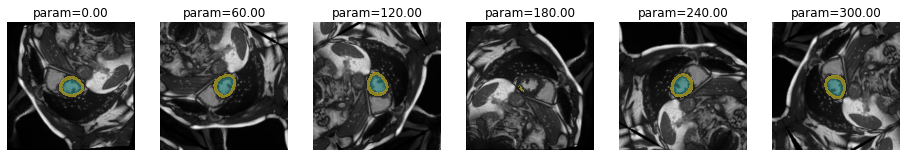

In [ ]:
plot_series(series)

In [ ]:
#export
def eval_rotation_series(image, mask, model, step=5, start=0, end=360,  param_name="deg", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        rotationTransform,
        start=start,
        end=end,
        step=step,
        mask_transform_function=rotationTransform,
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/72 [00:00<?, ?it/s]

alt.Chart(...)

You can easily generate gifs by plotting multiple frames

In [ ]:
gif_series(
    get_rotation_series(img(),trainedModel,start=0,end=360,step=5),
    "example/kaggle/rotation.gif",
    duration=150,
    param_name="degrees"
)

  0%|          | 0/72 [00:00<?, ?it/s]

![segmentation sensitivity to rotation](example/kaggle/rotation.gif)

### Cropping

In [ ]:
#export
def cropTransform(image, pxls, finalSize=256):
    image = image.clone()
    image = image.resize(finalSize)
    image = image.crop_pad(int(pxls))
    image = image.rotate(180)
    image = image.crop_pad(finalSize, padding_mode="zeros")
    image = image.rotate(180)
    return image

def get_crop_series(image, model, start=56, end=257, step=50, finalSize=256, **kwargs):
    return get_generic_series(image,model,partial(cropTransform,finalSize=finalSize), start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_crop_series(img(), trainedModel, truth=trueMask(), tfm_y=True, step=20)

  0%|          | 0/11 [00:00<?, ?it/s]

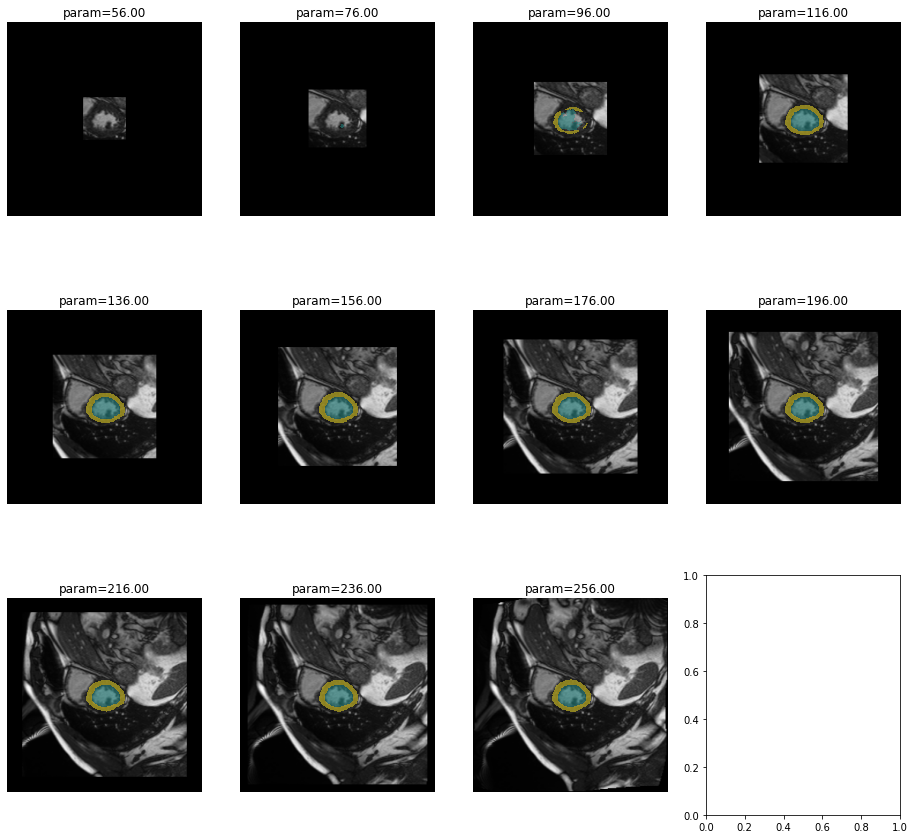

In [ ]:
plot_series(series,nrow=3,figsize=(16,15))#,overlay_truth=True)

In [ ]:
#export
def eval_crop_series(image, mask, model, step=5, start=56, end=256, finalSize=256, param_name="pixels", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(cropTransform,finalSize=finalSize),
        start=start,
        end=end,
        step=step,
        mask_transform_function=partial(cropTransform,finalSize=finalSize),
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_crop_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/40 [00:00<?, ?it/s]

alt.Chart(...)

Cropping and comparing to the full original mask might not be desired. In this case it is possible to crop the mask as well. All pixels in the cropped area are set to 0 (commonly the background class). As soon as a class is completely missing, the dice score might jump to 1 because not predicting the class is correct in that case.

In [ ]:
gif_series(
    get_crop_series(img(),trainedModel,start=256,end=16,step=-10),
    "example/kaggle/crop.gif",
    duration=150,
    param_name="pixels"
)

  0%|          | 0/24 [00:00<?, ?it/s]

![segmentation sensitivity to cropping](example/kaggle/crop.gif)

### Brightness

In [ ]:
#export
def brightnessTransform(image, light):
    return image.brightness(light)

def get_brightness_series(image, model, start=0.05, end=1, step=.1, **kwargs):
    return get_generic_series(image,model,brightnessTransform, start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_brightness_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/10 [00:00<?, ?it/s]

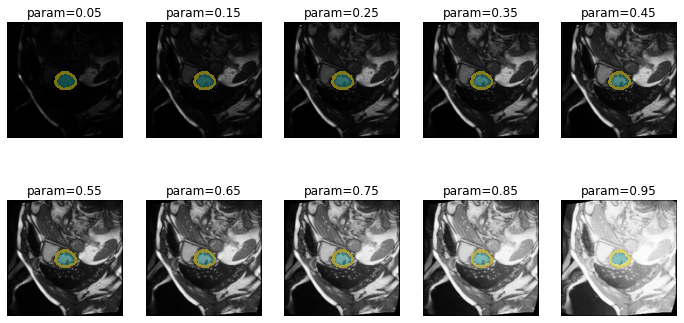

In [ ]:
plot_series(series, nrow=2, figsize=(12,6))

In [ ]:
#export
def eval_bright_series(image, mask, model, start=0.05, end=.95, step=0.05, param_name="brightness", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        brightnessTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_bright_series(img(), trueMask(), trainedModel, start=0, end=1.05, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/21 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_brightness_series(img(), trainedModel,step=.05),
    "example/kaggle/brightness.gif",
    param_name="brightness"
)

  0%|          | 0/19 [00:00<?, ?it/s]

![segmentation sensitivity to brightness](example/kaggle/brightness.gif)

### Contrast

In [ ]:
#export
def contrastTransform(image, scale):
    return image.contrast(scale)

def get_contrast_series(image, model, start=0.1, end=7.11, step=1, **kwargs):
    return get_generic_series(image,model,contrastTransform, start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_contrast_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/8 [00:00<?, ?it/s]

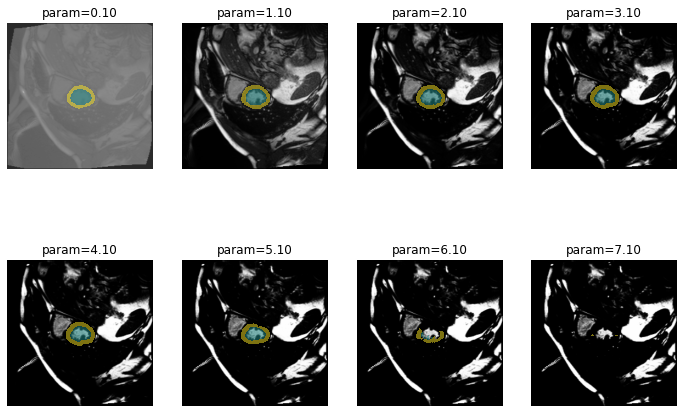

In [ ]:
plot_series(series, nrow=2, figsize=(12,8))

In [ ]:
#export
def eval_contrast_series(image, mask, model, start=0.1, end=7.1, step=0.5, param_name="contrast", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        contrastTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_contrast_series(img(), trueMask(), trainedModel, start=0, end=7, step=0.5, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/14 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_contrast_series(img(), trainedModel,step=.5),
    "example/kaggle/contrast.gif",
    param_name="contrast"
)

  0%|          | 0/15 [00:00<?, ?it/s]

![segmentation sensitivity to contrast](example/kaggle/contrast.gif)

### Zoom

In [ ]:
#export
def zoomTransform(image, scale, finalSize=256):
    image = image.resize(finalSize).clone()
    image = image.crop_pad(int(scale), padding_mode="zeros")
    image = image.resize(finalSize).clone()
    return image

def get_zoom_series(image, model, start=56, end=500, step=50, finalSize=256, **kwargs):
    return get_generic_series(image,model,partial(zoomTransform,finalSize=finalSize), start=start, end=end, step=step, **kwargs)

In [ ]:
series = get_zoom_series(img(), trainedModel, truth=trueMask())

  0%|          | 0/9 [00:00<?, ?it/s]

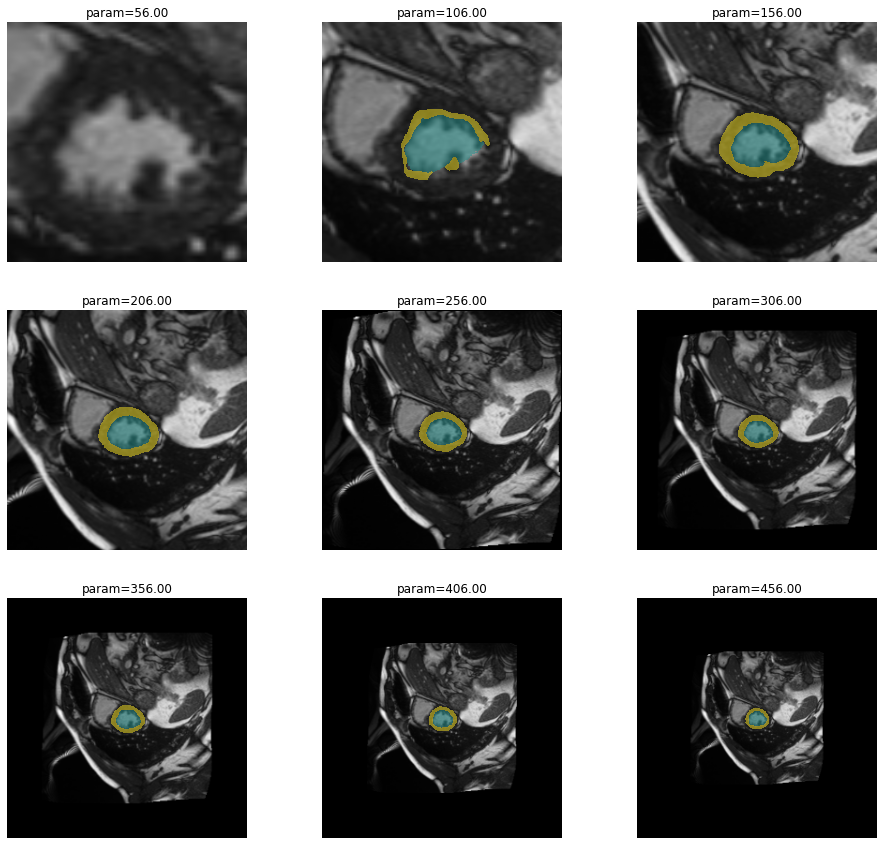

In [ ]:
plot_series(series, nrow=3, figsize=(16,15))

In [ ]:
#export
def eval_zoom_series(image, mask, model, step=10, start=56, end=500, finalSize=256, param_name="scale", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(zoomTransform,finalSize=finalSize),
        start=start,
        end=end,
        step=step,
        mask_transform_function=partial(zoomTransform,finalSize=finalSize),
        param_name=param_name,
        **kwargs
    )

In [ ]:
results = eval_zoom_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/45 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_zoom_series(img(),trainedModel,start=500,end=16,step=-10),
    "example/kaggle/zoom.gif",
    duration=250,
    param_name="scale"
)

  0%|          | 0/49 [00:00<?, ?it/s]

![segmentation sensitivity to zoom](example/kaggle/zoom.gif)

### Dihedral

In [ ]:
#export
def dihedralTransform(image, sym_im):
    return image.dihedral(k=int(sym_im))

def get_dihedral_series(image, model, start=0, end=8, step=1, **kwargs):
    return get_generic_series(image,model,dihedralTransform, start=start, end=end, step=step, **kwargs)

  0%|          | 0/8 [00:00<?, ?it/s]

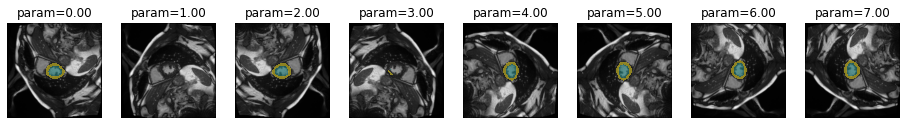

In [ ]:
plot_series(get_dihedral_series(img(), trainedModel))

In [ ]:
#export
def eval_dihedral_series(image, mask, model, start=0, end=8, step=1, param_name="k", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        dihedralTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        mask_transform_function=dihedralTransform,
        **kwargs
    )

In [ ]:
results = eval_dihedral_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results, chart_type="point")

  0%|          | 0/8 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_dihedral_series(img(), trainedModel),
    "example/kaggle/dihedral.gif",
    param_name="k",
    duration=1000
)

  0%|          | 0/8 [00:00<?, ?it/s]

![segmentation sensitivity to dihedral](example/kaggle/dihedral.gif)

### Resize

In [ ]:
#export
def resizeTransform(image, size):
    return image.resize(int(size)).clone()

In [ ]:
#export
def get_resize_series(image, model, start=10, end=200, step=30, **kwargs):
    return get_generic_series(image,model,resizeTransform, start=start, end=end, step=step, **kwargs)

  0%|          | 0/7 [00:00<?, ?it/s]

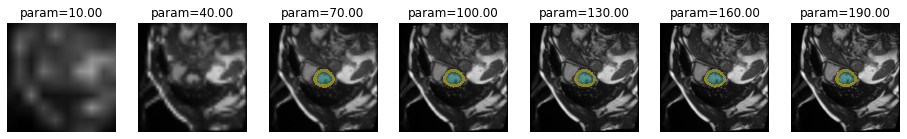

In [ ]:
plot_series(get_resize_series(img(), trainedModel), sharex=True, sharey=True)

In [ ]:
#export
def eval_resize_series(image, mask, model, start=22, end=3000, step=100, param_name="px", **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        resizeTransform,
        start=start,
        end=end,
        step=step,
        param_name=param_name,
        mask_transform_function=resizeTransform,
        **kwargs
    )

In [ ]:
results = eval_resize_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_eval_series(results)

  0%|          | 0/30 [00:00<?, ?it/s]

alt.Chart(...)

In [ ]:
gif_series(
    get_resize_series(img(), trainedModel),
    "example/kaggle/resize.gif",
    param_name="px",
    duration=200
)

  0%|          | 0/7 [00:00<?, ?it/s]

![segmentation sensitivity to resizing](example/kaggle/resize.gif)

## More on Evaluation

The default score for evaluation is the Dice-Score calculated separately for each component.
In addition to Dice, `misas` provides functions for component-wise functions for precission and recall but you can easily define your own.

In [ ]:
results_dice = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'])
plot_dice = plot_eval_series(results_dice, value_vars=['bg','LV','MY'])

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
results_recall = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'], eval_function=recall_by_component)
plot_recall = plot_eval_series(results_recall, value_vars=['bg','LV','MY'])

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
results_precision = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'], eval_function=precision_by_component)
plot_precision = plot_eval_series(results_precision, value_vars=['bg','LV','MY'])

  0%|          | 0/72 [00:00<?, ?it/s]

The objects returned by the plot function are `altair` graphs that can be further customized and combined

In [ ]:
plot_dice = plot_dice.properties(title="Dice")
plot_precision = plot_precision.properties(title="Precision")
plot_recall = plot_recall.properties(title="Recall")

In [ ]:
plot_dice & plot_precision & plot_recall

alt.VConcatChart(...)

In order to define your own evaluation function you need to define a function with the predicted and true masks as first and second parameter and the component to evaluate as third parameter.
Masks are of type ImageSegment and you can access the tensor data using the `.data` property.
This is an example on how to define specificity. This can than be passed as evaluation function.

In [ ]:
def specificity_by_component(predictedMask, trueMask, component = 1):
    specificity = Tensor([1])
    pred = predictedMask.data != component
    msk = trueMask.data != component
    intersect = pred&msk
    total = pred.sum() + msk.sum() 
    if total > 0:
        specificity = intersect.sum().float() / msk.sum()
    return specificity.item()

In [ ]:
results_specificity = eval_rotation_series(img(), trueMask(), trainedModel, components=['bg','LV','MY'], eval_function=specificity_by_component)
plot_specificity = plot_eval_series(results_specificity, value_vars=['bg','LV','MY'])
plot_specificity

  0%|          | 0/72 [00:00<?, ?it/s]

alt.Chart(...)

The specificity for the background class degrades so dramatically for rotations of around 180 degrees as the LV and MY classes are no longer detected at all. So there are no "true negatives" for the background class, consequently specificity for that class drops to zero.

## Confusion Matrices

Confusion matrices are useful to evaluate in more detail which classes the model gets wrong. To conveniently generate separate confusion matrices or series `misas` provides some convenience functions.

In [ ]:
series = get_rotation_series(img(), trainedModel, truth=trueMask(), tfm_y=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#export
def get_confusion(prediction, truth, max_class=None):
    if not max_class:
        max_class = max(prediction.data.max(), truth.data.max())
    # https://stackoverflow.com/a/50023660
    cm = np.zeros((max_class+1, max_class+1), dtype=int)
    np.add.at(cm, (prediction.data, truth.data), 1)
    return cm

The `get_confusion` function returns a two dimensional `numpy` array with counts for each class combination.
The true class is along the columns and the predicted class along the rows. The number of classes is derived from the data if not provided as `max_class` parameter. This parameter is important if the given instance of prediction and truth does not contain all available classes.

In [ ]:
cm = get_confusion(series[0][2], series[0][3])
cm

array([[63867,     0,    20],
       [    7,   754,    68],
       [  148,    17,   655]])

This matrix shows that there are 754 pixels classified correctly as "LV" (class=1). However, there are also 17 pixels that are in reality "LV" but predicted as "MY". Accordingly, there are 68 pixels that are "MY" but predicted as "LV".

Looking at tables is much less convenient and informative than looking at graphics so let's plot this matrix

In [ ]:
#export
def plot_confusion(confusion_matrix, norm_axis=0, components=None, ax=None, ax_label=True, cmap="Blues"):
    cm = confusion_matrix / confusion_matrix.sum(axis=norm_axis, keepdims=True)
    if not components:
        components = ["c" + str(i) for i in range(cm.shape[0])]
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(cm, cmap=cmap)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(components)))
    ax.set_yticks(np.arange(len(components)))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(components)
    ax.set_yticklabels(components)
    
    # label axes
    if ax_label:
        ax.set_xlabel("truth")
        ax.set_ylabel("prediction")
    
    # label cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, round(cm[i, j],2),
                           ha="center", va="center")
    
    return ax

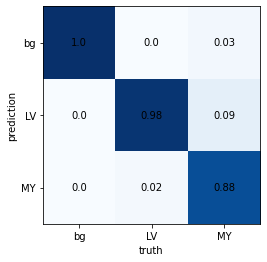

In [ ]:
_ = plot_confusion(cm, components=["bg","LV","MY"])

This is the confusion matrix for one image. Next we want to look at the confusion matrix for a full series of transformed (in this case rotated) images.

In [ ]:
#export
def plot_confusion_series(
        series,
        nrow=1,
        figsize=(16,6),
        param_name='param',
        cmap="Blues",
        components=None,
        norm_axis=0,
        **kwargs
    ):
    fig, axs = plt.subplots(nrow,math.ceil(len(series)/nrow),figsize=figsize,**kwargs)
    for element, ax in zip(series, axs.flatten()):
        param,img,pred,truth = element
        cm = get_confusion(pred,truth)
        plot_confusion(cm, ax=ax, components=components, ax_label=False, norm_axis=norm_axis, cmap=cmap)

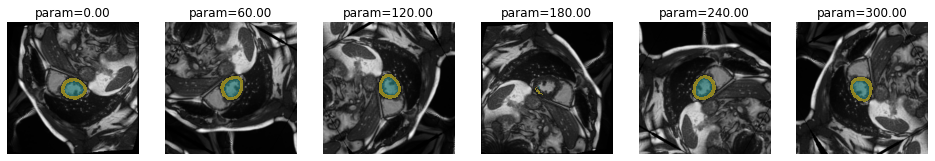

In [ ]:
plot_series(series,figsize=(16.5,6))

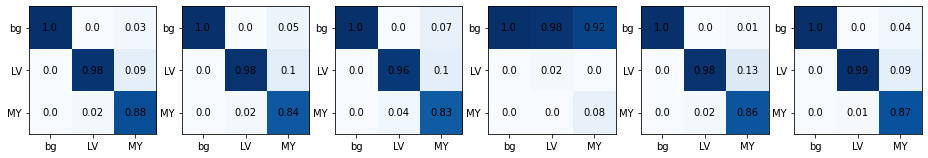

In [ ]:
plot_confusion_series(series, components=['bg','LV','MY'])